In this notebook we will experiment with the AL bias mitigation technique from Richards. 
We will do this on a synthetically biased sample (sample size=700) that we obtained from the CERN dataset, with the rf classifier trained on 10 percent of the data and using a=1/28 and k=0 for the bin distribution

In [ ]:
# Some notes:
# - If you use df.loc[i], you get the instance that had index i in the original dataframe.
# - If you use df.l=iloc[i], you get the ith instance n the current dataframe.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from time import time

# Import data

In [2]:
def read_file(url):

    url = url + "?raw=true"
    df = pd.read_csv(url, encoding='cp1252', sep=',', low_memory=False)
    return df

In [109]:
# df = pd.read_csv('CERN_sampled_rf_0.1_dis_004_000_700.csv')
#df=pd.read_csv('CERN_testing_set_30_2000.csv')
#df=pd.read_csv('CERN_testing_set_5_100.csv')
#df=pd.read_csv('CERN_testing_set_50_300.csv')
df=pd.read_csv('CERN_testing_set_300_1000.csv')

In [121]:
url = "https://github.com/hannahgathu/Thesis-Data-Visualisations/blob/main/Data/dielectron_classification.csv"

df_og= read_file(url)

# Visualize data

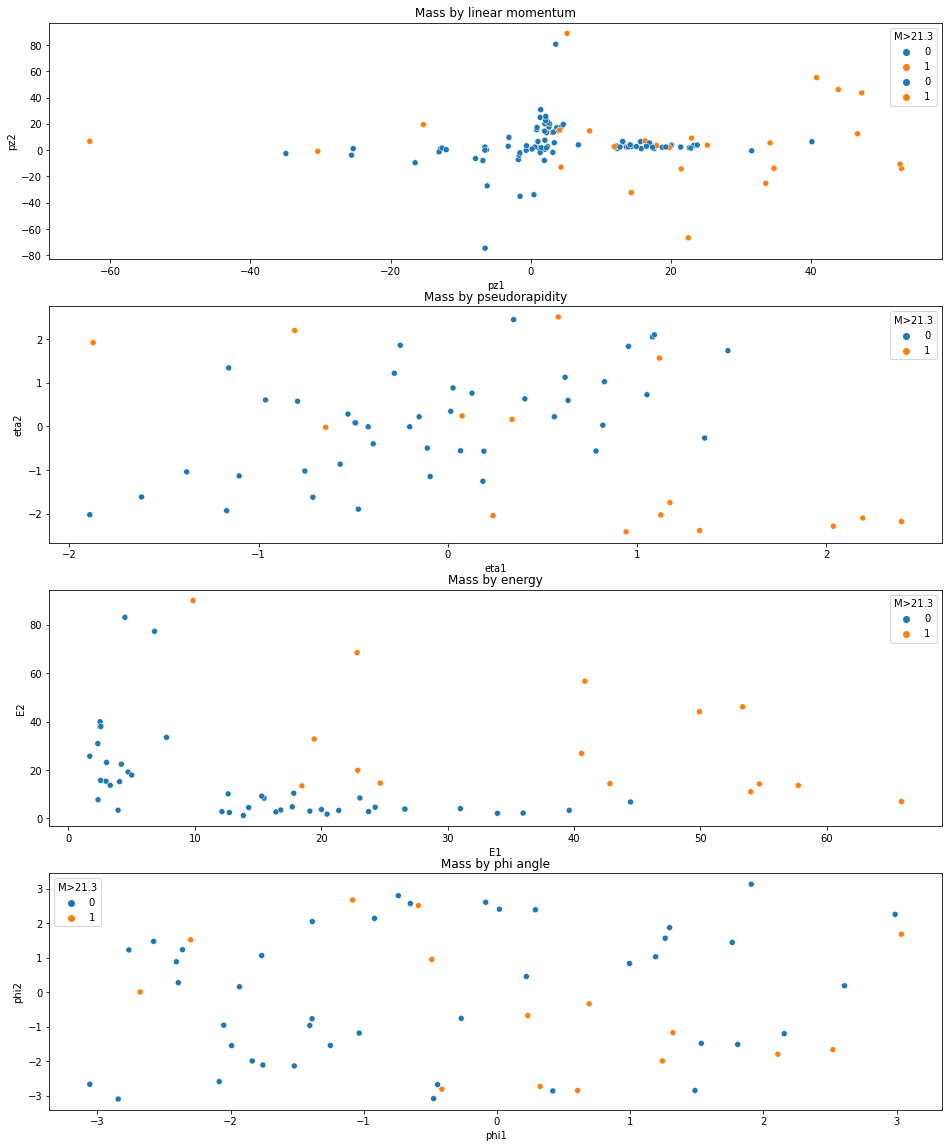

In [133]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=sample_og, x='pz1', y='pz2', hue='M>21.3')
ax[0].set_title('pz1 vs pz2')
sns.scatterplot(ax= ax[0],data=sample_og, x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=sample_og, x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=sample_og, x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=sample_og, x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

NameError: name 'sample_700' is not defined

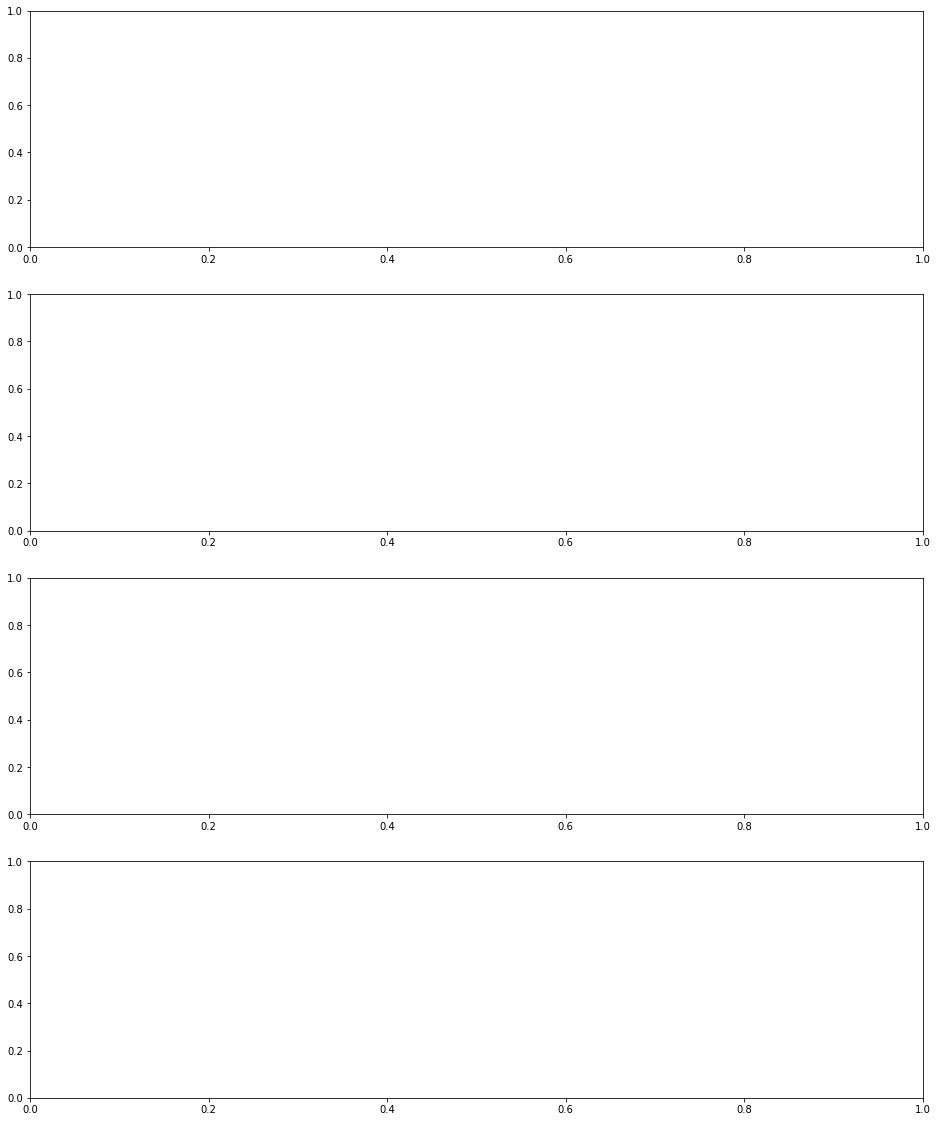

In [6]:
fig,ax = plt.subplots(nrows=4,ncols=1,figsize=(16,20))

sns.scatterplot(ax= ax[0],data=sample_700, x='pt1', y='pt2', hue='M>21.3')
ax[0].set_title('Mass by linear momentum')
sns.scatterplot(ax= ax[1],data=sample_700, x='eta1', y='eta2', hue='M>21.3')
ax[1].set_title('Mass by pseudorapidity')
sns.scatterplot(ax= ax[2],data=sample_700, x='E1', y='E2', hue='M>21.3')
ax[2].set_title('Mass by energy')
sns.scatterplot(ax= ax[3],data=sample_700, x='phi1', y='phi2', hue='M>21.3')
ax[3].set_title('Mass by phi angle')

plt.show()

# Prep data

In [110]:
# create sample and pool, the sample has size 700
df['s1']=df['pz1']
df['s2']=df['pz2']

sample=df[df['in_biased_sample']==1]
pool=df[df['in_biased_sample']==0]


### Add extra bias

In [85]:
#add noise to s
for i in range(sample.shape[0]):
    sample['s1'].at[i]=sample['s1'][i]+np.random.normal(0,30)
    
#add noise to s
for i in range(sample.shape[0]):
    sample['s2'].at[i]=sample['s2'][i]+np.random.normal(0,30)

In [86]:
sample=sample[(sample['s1'] < 30) & (sample['s1']>-30) & (sample['s2'] < 30) & (sample['s2']>-30)]

In [87]:
sample_og=sample
pool_og=pool

In [88]:
sample_og.shape[0]

58

In [111]:
sample=sample_og
pool=pool_og

In [112]:
X=df.drop(columns=['M>21.3','M','Run','Event','in_biased_sample'])
y=df.M>21.3
X_pool=pool.drop(columns=['M>21.3','M','Run','Event','in_biased_sample'])
X_sample = sample.drop(columns=['M>21.3','M','Run','Event','in_biased_sample'])
y_pool=pool.M>21.3
y_sample=sample.M>21.3

## Visualize sample

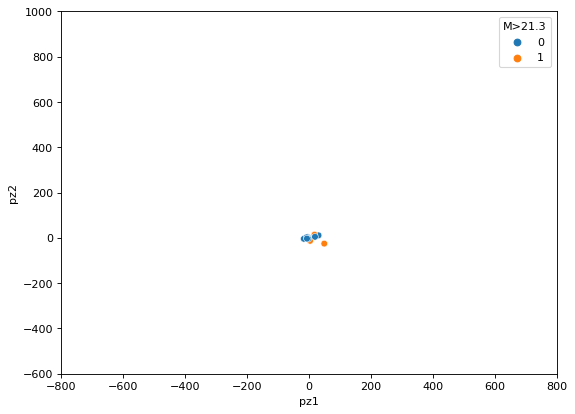

In [49]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=sample, x='pz1', y='pz2', hue=df['M>21.3'] )
plt.xlim([ -800,800])
plt.ylim([-600, 1000])
ax = plt.gca()

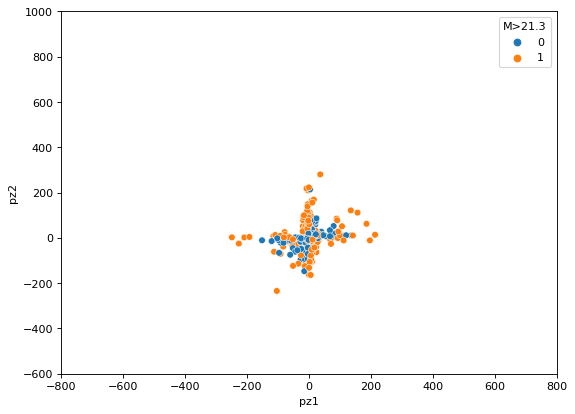

In [10]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=pool, x='pz1', y='pz2', hue=df['M>21.3'] )
plt.xlim([ -800,800])
plt.ylim([-600, 1000])
ax = plt.gca()

# Train rf classifier

In [113]:
#train classifier on sample
rf = RandomForestClassifier()
t0 = time()
rf.fit(X_sample, y_sample)
print ('training time: ', round(time()-t0, 3), 's')

training time:  0.119 s


In [114]:
#accuracy on X (whole set)
t1=time()
pred_rf = rf.predict(X)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y, pred_rf))

predicting time:  0.016 s
Accuracy: 0.6653846153846154


In [80]:
#accuracy on sample
t1=time()
pred_rf_sample = rf.predict(X_sample)
print ('predicting time: ', round(time()-t1, 3), 's')
print("Accuracy:",metrics.accuracy_score(y_sample, pred_rf_sample))


predicting time:  0.01 s
Accuracy: 1.0


## Random Forest

In [15]:
##get proximity matrix
def get_proximity_matrix(X, rf):
    
    #find proportion of indices that match between i and j
    #compute the symmetric matrix
    
    n=X.shape[0]
    tree_idxs = rf.apply(X)
    proximity_matrix = np.empty(shape=(n, n))
    
    for i in range(n):
        for j in range(n):
            proximity_matrix[i,j] = np.sum(np.equal(tree_idxs[i,:], tree_idxs[j,:]))
    return proximity_matrix

In [16]:
##get maximum probabilities
def get_max_class_probabilities(X,rf):
    class_probabilities= rf.predict_proba(X)
    max_class_probabilities=[0]*(len(class_probabilities))
    for i in range (len(class_probabilities)):
        max_class_probabilities[i]=max(class_probabilities[i,0],class_probabilities[i,1])
    return max_class_probabilities

In [17]:
#X=training set, pool=pool of instances to pick from
rf = RandomForestClassifier()
rf.fit(X_sample,y_sample)
#proximity_matrix=get_proximity_matrix(X+pool,rf)

RandomForestClassifier()

## AL query functions

In [18]:
def get_sum_of_proximities(i1, ys, proximity_matrix):
    proximities=[0]*len(ys)
    for i in range(len(ys)):
        proximities[i]=proximity_matrix[i,i1]
    sum_of_proximities=sum(proximities)
    return sum_of_proximities
        

In [98]:
def s_2(i, pool, proximity_matrix):
    S_2 = get_sum_of_proximities(i, X_sample.index, proximity_matrix)*(1-max_class_probabilities[i])/(get_sum_of_proximities(i,X_pool.index, proximity_matrix)+1)
    return S_2

def uncertainty(i):
    return (1- max_class_probabilities[i])
    
def query_instance (X_sample, X_pool, rf):
    proximity_matrix = get_proximity_matrix(X, rf)
    max_class_probabilities= get_max_class_probabilities(X, rf)
    s_2_scores=[0]*X_pool.shape[0]
    #uncertainty_scores=[0]*X_pool.shape[0]
    for i in range(X_pool.shape[0]):
        s_2_scores[i]=s_2(int(X_pool.iloc[i].iloc[0]), X_pool, proximity_matrix)
        #uncertainty_scores[i]= uncertainty(int(X_pool.iloc[i].iloc[0]))
    
    queried_instance_index = int(X_pool.iloc[np.argmax(s_2_scores)].iloc[0])
    #queried_instance_index = int(X_pool.iloc[np.argmax(uncertainty_scores)].iloc[0])
    return queried_instance_index
    #what I want to do:
    #get all values of s2 for the instances in the pool in a list
    #get the argmax, which gives the index i with the highest s2 score
    #get the instancce from the pool by using 
    #int(X_sample.iloc[0].iloc[0])

## AL algorithm

In [155]:
# initialization of AL algorithm:
queried_instances=[]
rf = RandomForestClassifier()
n_of_iterations=500
accuracies=[0]*n_of_iterations
t0 = time()
for i in range(n_of_iterations):
    # one iteration of the AL algorithm:
    #retrain classifier
    rf.fit(X_sample, y_sample)
    #print ('cp1: ', round(time()-t0, 3), 's')
    
    #store accuracy
    pred_rf = rf.predict(X)
    accuracy = metrics.accuracy_score(y, pred_rf)
    accuracies[i] = accuracy
    #print (accuracy)
    #print ('cp2: ', round(time()-t0, 3), 's')
    
    #query instance and add to sample
    #proximity_matrix = get_proximity_matrix(X, rf)
    #print ('cp3: ', round(time()-t0, 3), 's')
    max_class_probabilities= get_max_class_probabilities(X, rf)
    #print ('cp4: ', round(time()-t0, 3), 's')
    n = query_instance(X_sample, X_pool, rf)
    #print ('cp5: ', round(time()-t0, 3), 's')
    X_pool=X_pool.drop(n)
    y_pool=y_pool.drop(n)
    X_sample = X_sample.append(X.loc[n])
    y_sample = pd.concat([y_sample, pd.DataFrame([y.loc[n]])], axis = 0)
    queried_instances.append(n)
    
#store accuracy
pred_rf = rf.predict(X)
accuracy = metrics.accuracy_score(y, pred_rf)
accuracies[n_of_iterations-1] = accuracy
print (accuracy)


<ipython-input-155-437f92160b6d>:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_sample.drop(X_sample.columns[0], axis=1).drop(X_sample.columns[1], axis=1), y_sample)


NameError: name 'X_og' is not defined

In [116]:
accuracies_with_diversity_1000=accuracies

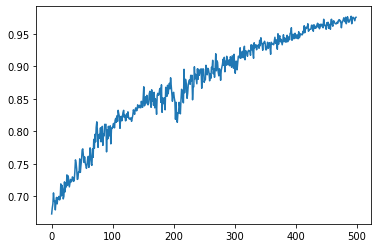

In [117]:
#ended with 97 percent accuracy
plt.plot(accuracies_with_diversity_1000)

Text(0.5, 1.0, 'Accuracy for 500 iterations with sample size 58 and pool size 1000')

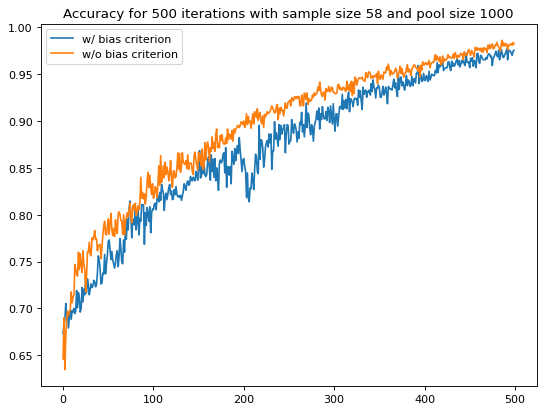

In [119]:
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_with_diversity_1000, label="w/ bias criterion")
plt.plot(accuracies_uncertainty_only_1000, label="w/o bias criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracy for 500 iterations with sample size 58 and pool size 1000")

In [141]:
#get unbiased testset:
#split data
y=df_og.M>21.3
#additional to dropping the endpoints we also drop the run and event numbers, because those aren't predictors
X=df_og.drop(columns=['M>21.3','M','Run','Event'])
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [128]:
X_test=X_test.drop('in_biased_sample',axis=1)

In [142]:
X_test.shape[0]

30000

In [144]:
rf.feature_importances_

array([0.05995169, 0.038423  , 0.06770753, 0.04691209, 0.04948284,
       0.0596395 , 0.07163295, 0.06550861, 0.04102114, 0.00686202,
       0.0611791 , 0.0465015 , 0.04992928, 0.05744119, 0.06245223,
       0.06244987, 0.03970564, 0.00498442, 0.06225255, 0.04596285])

In [143]:
#store accuracy
pred_rf = rf.predict(X_test)
accuracy_og = metrics.accuracy_score(y_test, pred_rf)
print(accuracy_og)

ValueError: X has 16 features, but DecisionTreeClassifier is expecting 20 features as input.

In [96]:
#starting accuracy: 67 percent. final accuracy: 98 percent
accuracies_uncertainty_only_1000=accuracies

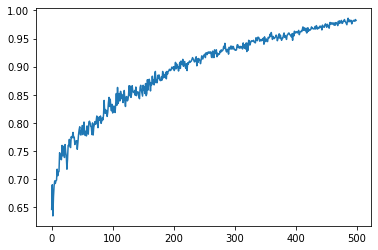

In [97]:
plt.plot(accuracies_uncertainty_only_1000)

In [53]:
accuracies_uncertainty_only=accuracies

In [59]:
accuracies_with_diversity=accuracies

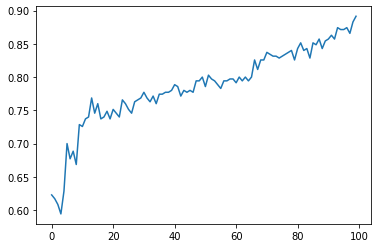

In [54]:
plt.plot(accuracies_uncertainty_only)

Text(0.5, 1.0, 'Accuracy for 100 iterations with sample size 12 and pool size 300')

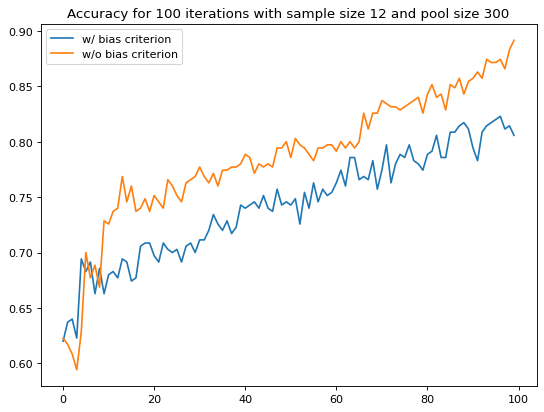

In [62]:
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_with_diversity, label="w/ bias criterion")
plt.plot(accuracies_uncertainty_only, label="w/o bias criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracy for 100 iterations with sample size 12 and pool size 300")

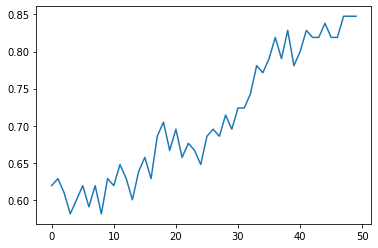

In [165]:
plt.plot(accuracies)

Text(0.5, 1.0, 'Accuracies /w uncertainty only')

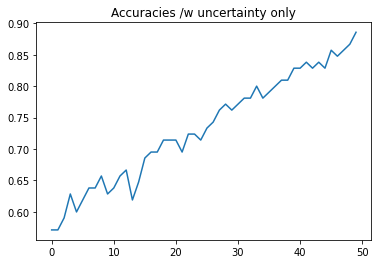

In [196]:
plt.plot(accuracies)
ax = plt.gca()
ax.set_title("Accuracies /w uncertainty only)

In [ ]:
accuracies_100_it_uncertainty=accuracies

Text(0.5, 1.0, 'Accuracies')

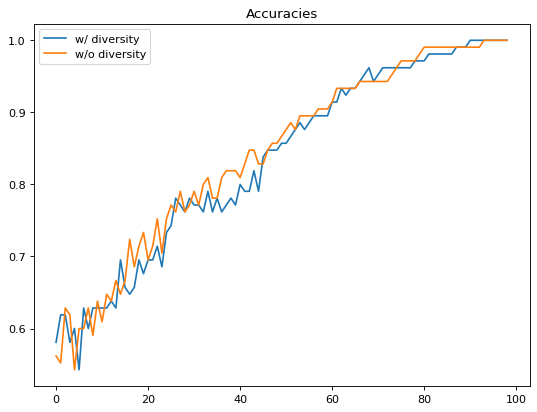

In [228]:
figure(figsize=(8, 6), dpi=80)
plt.plot(accuracies_100_it, label="w/ bias criterion")
plt.plot(accuracies_100_it_uncertainty, label="w/o bias criterion")
plt.legend(loc='best')
ax = plt.gca()
ax.set_title("Accuracies")

Text(0.5, 1.0, 'Accuracies, 100 iterations')

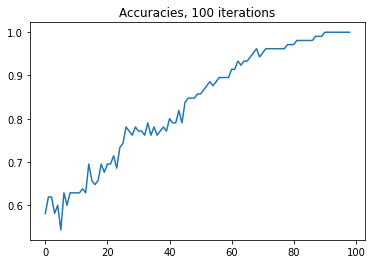

In [211]:
accuracies_100_it=accuracies
plt.plot(accuracies)
ax = plt.gca()
ax.set_title("Accuracies, 100 iterations")

Text(0.5, 1.0, 'Queried Instances')

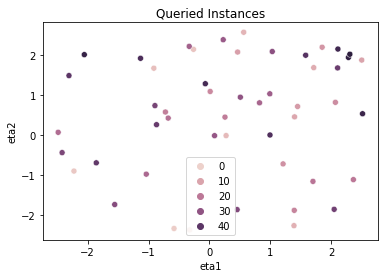

In [176]:
sns.scatterplot(data=X.loc[queried_instances], x='eta1', y='eta2', hue=range(len(queried_instances)))
ax = plt.gca()
ax.set_title("Queried Instances")

Text(0.5, 1.0, 'Queried Instances')

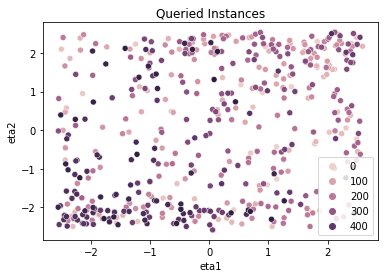

In [137]:
sns.scatterplot(data=X.loc[queried_instances], x='eta1', y='eta2', hue=range(len(queried_instances)))
ax = plt.gca()
ax.set_title("Queried Instances")

Text(0.5, 1.0, 'Queried Instances')

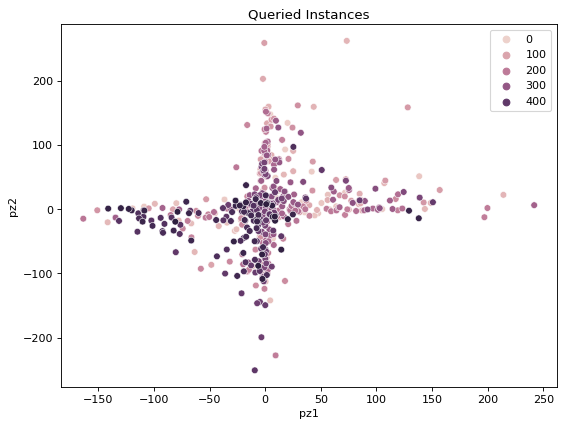

In [139]:
figure(figsize=(8, 6), dpi=80)
sns.scatterplot(data=X.loc[queried_instances], x='pz1', y='pz2', hue=range(len(queried_instances)))
ax = plt.gca()
ax.set_title("Queried Instances")